In [23]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 4)

import os
import pandas as pd

from DBQuerier import DBQuerier as Querier
# from TF_Trainer import TF_Trainer

from crawlab_toolbox import plotting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA

from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras as keras
   
from scipy import signal
from matplotlib.pyplot import colorbar
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
import matplotlib.dates as mdates
import matplotlib as mpl

import seaborn as sns
sns.set(style="ticks")

from crawlab_toolbox import plotting as genplt
import json
import numpy as np
import datetime

import ast
tf.random.set_seed(1234)
import matplotlib.colors as colors


# first Program - BAD
## Start: 2020-06-18 15:15:54.316000
## End: 2020-06-18 15:32:11.656000

# First Program - GOOD
## Start: 2020-06-18 15:44:51.232000
## End: 2020-06-18 15:59:15.697000

# Second Program - GOOD
## Start: 
## End:
Lines 179-211, 235-end
Samples -1, -3, -4 are BAD





In [24]:
querier = Querier('db18','MMM-EMCO-E350',limit=None)
query = """SELECT  FFT.dateTime AS dateTime, 
        FFT.values AS vals, 
        VibrationState.values as vibState,
        VibrationState.programName as programName, VibrationState.itemInstanceId as itemInstanceId,
        Vibration.values as vibClass,
        RMS.values as rmsVals
        FROM db18.FFT
        LEFT JOIN db18.VibrationState ON 
        db18.VibrationState.dateTime = db18.FFT.dateTime 
        LEFT JOIN db18.Vibration ON
        db18.Vibration.dateTime = db18.FFT.dateTime
        LEFT JOIN db18.RMS ON
        db18.RMS.dateTime = db18.FFT.dateTime
        where exists 
            (SELECT VibrationState.values from db18.VibrationState WHERE VibrationState.dateTime = Vibration.dateTime)
         
           and ((VibrationState.itemInstanceId = 'GOOD') or (VibrationState.itemInstanceId = 'BAD')) and VibrationState.motionType = 'Feed' and VibrationState.dateTime between '2020-06-18 00:00:00.000000' and '2020-06-20 00:00:00.000000'
        order by Vibration.dateTime asc ; """

cursor = querier.execute_query(query)


In [25]:
data=cursor.fetchall()

In [26]:
# sensorId = np.array([[data[i][0] for i in range(len(data))]]).T
dateTime = np.array([[data[i][0] for i in range(len(data))]]).T
values = np.array([np.array(ast.literal_eval(data[i][1])) for i in range(len(data))])
vibState = np.array([[float(data[i][2].replace('RPM','')) / 10000. for i in range(len(data))]]).T
# programName = np.array([[data[i][4] for i in range(len(data))]]).T
itemInstanceId = np.array([[data[i][4] for i in range(len(data))]]).T
vibClass = np.array([ast.literal_eval(data[i][5]) for i in range(len(data))])
rmsVals = np.array([[data[i][6] for i in range(len(data))]]).T

In [27]:
# np.save('data/include_index_validation.npy',include_index)
include_index = np.load('data/include_index_validation.npy',allow_pickle=True)

In [30]:
itemInstanceId_pruned = itemInstanceId.flatten()[include_index.astype(int)]
vibClass_pruned = vibClass.flatten()[include_index.astype(int)]
print(itemInstanceId_pruned.shape)

dateTime_pruned = dateTime.flatten()[include_index.astype(int)]
values_pruned = values[include_index.astype(int),:]
rmsVals_pruned = rmsVals.flatten()[include_index.astype(int)]

bad_args = np.argwhere(itemInstanceId_pruned.flatten() == 'BAD')
good_args = np.argwhere(itemInstanceId_pruned.flatten() == 'GOOD')


y_true = np.ones(vibClass_pruned.shape[0])
y_true[good_args] = 0.


bad_cutoff = int(bad_args.shape[0] * 0.66)
good_cutoff = int(good_args.shape[0] * 0.66)
bad_train = bad_args[:bad_cutoff]
bad_test = bad_args[bad_cutoff:]
good_train = good_args[:good_cutoff]
good_test = good_args[good_cutoff:]

train_args = np.concatenate((good_train.flatten(),bad_train.flatten()))
test_args = np.concatenate((good_test.flatten(),bad_test.flatten()))
np.save('data/classification-Bad-v1.npy',vibClass_pruned.flatten()[bad_args])
np.save('data/classification-Good-v1.npy',vibClass_pruned.flatten()[good_args])


XY_full = np.hstack((values_pruned,y_true[...,np.newaxis]))

(667,)


In [19]:
XY_train = XY_full[train_args,:]
XY_test = XY_full[test_args,:]

# np.save('data/XY_train_valid.npy',XY_train)
# np.save('data/XY_test_valid.npy',XY_test)

In [20]:
XY_train.shape
XY_test.shape

(227, 2050)

In [22]:
XY_train[0,-1]

0.0

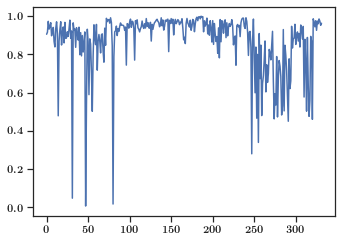

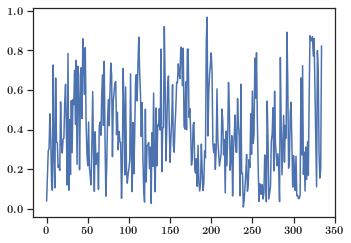

In [21]:

plt.plot(vibClass_pruned.flatten()[bad_args])
plt.show()


plt.plot(vibClass_pruned.flatten()[good_args])
plt.show()


In [768]:
def fit_statistics(y_true, y_pred):

    conf_matrix = np.round(confusion_matrix(y_true, y_pred) / y_pred.shape[0],2)
    
    # Null hypothesis: tool is healthy
    # Positive: Tool is unhealthy
    # Negative: Tool is healthy
    
    true_positive = conf_matrix[0,0]
    true_negative = conf_matrix[1,1]
    
    # False positive: tool is actually healthy but classified as unhealthy
    # | - | X |
    # | - | - |
    false_positive = conf_matrix[0,1]
    
    # False negative: tool is actually unhealthy but classified as healthy
    # | - | - |
    # | X | - |
    false_negative = conf_matrix[1,0]
    
    # Precision: Quantifies false positives
    # Recall: Quantifies false negatives
    
    if true_positive == 0 and false_positive == 0.:
        precision = 0.
    else:
        precision = true_positive / (true_positive + false_positive)
    
    if true_positive == 0. and false_negative == 0.:
        recall = 0.
        true_positive_rate = 0.
    else:
        recall = true_positive / (true_positive + false_negative)
        true_positive_rate = true_positive / (true_positive + false_negative)

    if true_negative == 0. and false_positive == 0.:
        true_negative_rate = 0.
    else:
        true_negative_rate = true_negative / (true_negative + false_positive)
    
    balanced_accuracy = (true_positive_rate + true_negative_rate) / 2
    
    return balanced_accuracy, true_positive_rate, true_negative_rate, precision, recall
 

In [771]:
y_pred = np.round(vibClass_pruned)
fit_statistics(y_true,y_pred)

(0.853925353925354,
 0.9459459459459459,
 0.7619047619047619,
 0.7,
 0.9459459459459459)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1.

In [760]:
goodClass = vibClass_pruned.flatten()[good_args]

print(goodClass[goodClass < 0.5].shape[0] / goodClass.shape[0])

0.6925373134328359


In [36]:
(dateTime[1] - dateTime[0]) / datetime.timedelta(seconds=1) / 60

array([0.053033333333333335], dtype=object)

In [72]:
# times_train = trainDF_original.index.values
# ts_train = (times_train - times_train[0]) / np.timedelta64(1, 's') / 60
# times_test = testDF_original.index.values
# ts_test = (times_test - times_test[0]) / np.timedelta64(1, 's') / 60
# times_full = fullDF_original.index.values
ts_full = (dateTime - dateTime[0]) / datetime.timedelta(seconds=1)


In [108]:
exclude_index = np.array([])
sample_num = 0

In [38]:
def plot_spectrogram(
            time,
            spectrogram,
            frequencyInterval,
            size=(12,6),
            showplot = False,
            save_plot = False,
            transparent = False,
            folder = None,
            filename = 'Spectrogram',
            xlabelpad = 5,    
            ylabelpad = 5,   
            file_type='pdf',
            date_format='%I:00 %p, %b %d',
            xlabel = 'Time',
            hertz = 'kHz'
            ):

    yi = np.arange(-0.0, spectrogram.shape[0] * frequencyInterval,frequencyInterval)
    xi = np.linspace(0.0,1,spectrogram.shape[1]) * np.amax(time)

    X, Y = np.meshgrid(xi, yi)
    plt.figure(figsize=size)
    
    print(X.shape)
    print(Y.shape)
    print(spectrogram.shape)

    # Customize the axes
    ax = plt.gca()
    plt.pcolormesh(X,Y,spectrogram,cmap='cividis',norm=colors.LogNorm(vmin=np.amin(spectrogram),vmax=np.amax(spectrogram)))

    ax.tick_params(labelsize=18)

    cbar = plt.colorbar()
    cbar.set_label(r'\textbf{Spectrum (g RMS)}', rotation=270,labelpad=22)
    plt.ylabel(r'\textbf{Frequency ('+ hertz +')}', labelpad=ylabelpad,fontsize=22)
    plt.xlabel(r'\textbf{' + xlabel + '}', labelpad=xlabelpad,fontsize=22)

    plt.tight_layout(pad=1.2)

    if save_plot:
        if folder is not None:
            # Ensure that the folder we want to save to exists
            if not os.path.exists(folder):
                os.makedirs(folder)

            filename = folder + '/' + filename

        # Save the pdf of the plot    
        if file_type == 'png':
            plt.savefig('{}.png'\
                    .format(filename),transparent=transparent)             
        elif file_type == 'pdf':
            plt.savefig('{}.pdf'\
                    .format(filename))    
        elif file_type == 'svg':
            plt.savefig('{}.svg'\
                    .format(filename)) 

    if showplot:
        plt.show()

    # Clear the axes and figure
    plt.clf()
    plt.cla()
    plt.close()

(2049, 798)
(2049, 798)
(2049, 798)


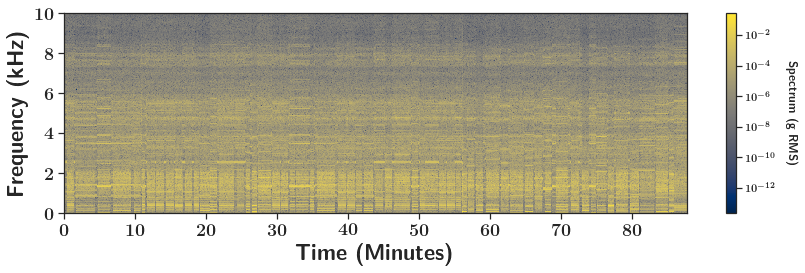

In [39]:
max_index = -1
frequencyInterval = 4.88281250
plot_spectrogram(
            ts_full,
            values.astype(float).T,
            frequencyInterval / 1000,
            size=(12,4),
            showplot = True,
            save_plot = False,
            transparent = True,
            folder = 'figures/',
            filename = 'Experiment-3-Spectrogram-Full',
            xlabelpad = 5,    
            ylabelpad = 5,   
            file_type='png',
#             date_format='%I:00 %p, %b %d',
            xlabel='Time (Minutes)'
            )

In [ ]:

        cursor = self.execute_query(query)
        

        if len(data) <= 0:
            return pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
 
        sensorId = np.array([[data[i][0] for i in range(len(data))]]).T
        dateTime = np.array([[data[i][1] for i in range(len(data))]]).T
        values = np.array([np.array(ast.literal_eval(data[i][2])) for i in range(len(data))])
        vibState = np.array([[float(data[i][3].replace('RPM','')) / 10000. for i in range(len(data))]]).T
        programName = np.array([[data[i][4] for i in range(len(data))]]).T
        
        columns = ['Values-{}'.format(i) for i in range(values.shape[1])]
        
        if table.lower() == 'fft':
            values = lin_log_interp(values).astype(float)
        
        if itemInstanceIdStr != '':
            columns = ['dateTime'] + columns + ['sensorId','VibState','programName','itemInstanceId']
            itemInstanceId = np.array([[data[i][5].replace('Sample-','').split('-')[0] for i in range(len(data))]]).T
            
            u, forward_indices = np.unique(itemInstanceId, return_index=True)
            u, backward_indices = np.unique(itemInstanceId[::-1], return_index=True)
            mask = np.hstack((forward_indices.flatten(),backward_indices.flatten()))
            
            indices = np.arange(0,itemInstanceId.shape[0])
            
            statsFeatures = np.hstack((dateTime,values,sensorId,vibState,programName,itemInstanceId))[indices[np.in1d(indices,mask,invert=True)],:]
        else:
            columns = ['dateTime'] + columns + ['sensorId','VibState','programName']
            statsFeatures = np.hstack((dateTime,values,sensorId,vibState,programName))
            
        featuresDF = pd.DataFrame(data=statsFeatures,columns=columns)
        featuresDF = featuresDF.set_index('dateTime')
        featuresDF.index = pd.to_datetime(featuresDF.index)
    
        cursor.close()
        self.disconnect()

        sensorIdDF = featuresDF.loc[:, featuresDF.columns == 'sensorId']
        vibStateDF = featuresDF.loc[:, featuresDF.columns == 'VibState']
        progNameDF = featuresDF.loc[:, featuresDF.columns == 'programName']
        featuresDF = featuresDF.drop(['sensorId','programName'],axis=1)
        
        self.minQueriedDate = np.amin(dateTime).strftime('%Y-%m-%d %H:%M:%S.%f')

        return featuresDF,sensorIdDF,programName


In [13]:
trainDF_original,testDF_original,fullDF_original = get_features('2020-03-10 00:00:00.000000','2020-03-11 00:00:00.000000',trainSamples,DoE=DoE)

2999-01-01 00:00:00.000000
vibration
SELECT Vibration.sensorId, 
        Vibration.dateTime AS dateTime, 
        Vibration.values AS vals, 
        VibrationState.values as vibState,
        VibrationState.programName as programName, VibrationState.itemInstanceId as itemInstanceId 
        FROM db18.Vibration
        LEFT JOIN db18.VibrationState ON 
        db18.VibrationState.dateTime = db18.Vibration.dateTime 
        where exists 
            (SELECT VibrationState.values from db18.VibrationState WHERE VibrationState.dateTime = Vibration.dateTime)
         
        and Vibration.assetId = 'MMM-EMCO-E350'
           and VibrationState.itemInstanceId like 'Sample-%' and VibrationState.motionType = 'Feed' and VibrationState.dateTime between '2020-03-10 00:00:00.000000' and '2020-03-11 00:00:00.000000'
        order by Vibration.dateTime desc ; 


In [15]:
fullDF_original.shape

(560, 4202)

In [16]:
trainDF_original.shape

(374, 4202)

In [17]:
testDF_original.shape

(186, 4202)

In [19]:
X_train,Y_train,DoE_train = create_fft_features(trainDF_original,DoE)
X_test,Y_test,DoE_test = create_fft_features(testDF_original,DoE)
X_full,Y_full,DoE_full = create_fft_features(fullDF_original,DoE)
num_samples,num_features = X_train.shape
DoE_train /= np.array([[300.,0.003,25]])
# freqs,X_train = fft_from_vib(X_train[:,:-1])
freqs,X_train = signal.welch(X_train[:,:-1], fs=20e3, nperseg=4096, scaling='spectrum')
freqs,X_test = signal.welch(X_test[:,:-1], fs=20e3, nperseg=4096, scaling='spectrum')
freqs,X_full = signal.welch(X_full[:,:-1], fs=20e3, nperseg=4096, scaling='spectrum')

Y_train = tf.keras.utils.to_categorical(Y_train, 2)
samples_train = np.array([trainDF_original['itemInstanceId'].values.astype(int)]).T

In [21]:
columns = ['Date']
# columns += ['FFT-' + str(i) for i in range(bearing1FFT.shape[1])]
times_train = trainDF_original.index.values
ts_train = (times_train - times_train[0]) / np.timedelta64(1, 's') / 60
times_test = testDF_original.index.values
ts_test = (times_test - times_test[0]) / np.timedelta64(1, 's') / 60
times_full = fullDF_original.index.values
ts_full = (times_full - times_full[0]) / np.timedelta64(1, 's') / 60


In [25]:
np.save('data/X_train_Full.npy',X_train)
np.save('data/X_test_Full.npy',X_test)
np.save('data/X_Full.npy',X_full)
np.save('data/time_minutes_train.npy',ts_train)
np.save('data/time_minutes_test.npy',ts_test)
np.save('data/time_minutes_full.npy',ts_full)

In [23]:
def plot_spectrogram(
            time,
            spectrogram,
            frequencyInterval,
            size=(12,4),
            showplot = False,
            save_plot = False,
            transparent = False,
            folder = None,
            filename = 'Spectrogram',
            xlabelpad = 5,    
            ylabelpad = 5,   
            file_type='pdf',
            date_format='%I:00 %p, %b %d',
            xlabel = 'Time'
            ):

    yi = np.arange(-0.0, spectrogram.shape[0] * frequencyInterval,frequencyInterval)
    xi = np.linspace(0.0,1,spectrogram.shape[1]) * np.amax(time)

    X, Y = np.meshgrid(xi, yi)
    plt.figure(figsize=size)
    
    print(X.shape)
    print(Y.shape)
    print(spectrogram.shape)

    # Customize the axes
    ax = plt.gca()
    plt.pcolormesh(X,Y,spectrogram,cmap='cividis',norm=colors.LogNorm(vmin=np.amin(spectrogram),vmax=np.amax(spectrogram)))

    ax.tick_params(labelsize=18)

    cbar = plt.colorbar()
    cbar.set_label(r'\textbf{PSD ($V^2 / Hz$)}', rotation=270,labelpad=20)
    plt.ylabel(r'\textbf{Frequency (Hz)}', labelpad=ylabelpad,fontsize=22)
    plt.xlabel(r'\textbf{' + xlabel + '}', labelpad=xlabelpad,fontsize=22)

    plt.tight_layout(pad=1.2)

    if save_plot:
        if folder is not None:
            # Ensure that the folder we want to save to exists
            if not os.path.exists(folder):
                os.makedirs(folder)

            filename = folder + '/' + filename

        # Save the pdf of the plot    
        if file_type == 'png':
            plt.savefig('{}.png'\
                    .format(filename),transparent=transparent)             
        elif file_type == 'pdf':
            plt.savefig('{}.pdf'\
                    .format(filename))    
        elif file_type == 'svg':
            plt.savefig('{}.svg'\
                    .format(filename)) 

    if showplot:
        plt.show()

    # Clear the axes and figure
    plt.clf()
    plt.cla()
    plt.close()

In [64]:
spectrogram = X_train.astype(float).T
frequencyInterval = freqs[1]

In [65]:
X_train

array([[5.05732487e-06, 1.42297267e-07, 1.95178745e-06, ...,
        5.10879516e-08, 7.48574109e-08, 5.03066069e-08],
       [2.97975987e-07, 8.95482685e-07, 2.85937040e-06, ...,
        4.59050433e-08, 9.12689728e-08, 1.02547496e-07],
       [1.89841126e-06, 8.65133032e-08, 6.60130445e-06, ...,
        2.82628783e-08, 1.01062989e-08, 3.25607874e-10],
       ...,
       [9.20534376e-07, 3.26503937e-07, 1.67138512e-06, ...,
        1.21637385e-07, 8.45867731e-08, 7.25023384e-08],
       [4.54396911e-07, 7.29966416e-07, 7.45520936e-07, ...,
        1.74269346e-08, 1.37556313e-07, 2.00833597e-07],
       [4.11224664e-06, 1.29172463e-06, 1.67650524e-06, ...,
        9.36689926e-09, 1.61439928e-09, 2.48495002e-09]], dtype=float32)

(2048, 374)
(2048, 374)
(2048, 374)


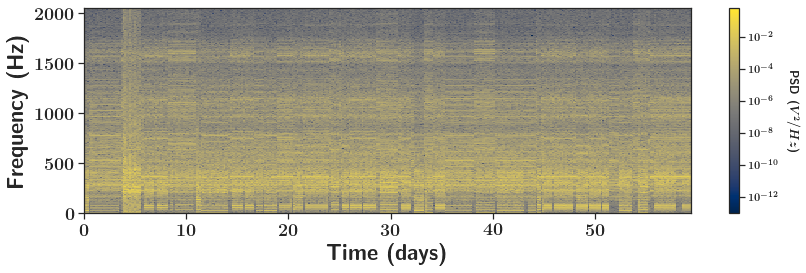

In [66]:
plot_spectrogram(
            ts,
            spectrogram,
            1,
            size=(12,4),
            showplot = True,
            save_plot = False,
            transparent = True,
            folder = 'Figures/IMS2_Spectrogram/',
            filename = 'Bearing1_Spectrogram',
            xlabelpad = 5,    
            ylabelpad = 5,   
            file_type='png',
#             date_format='%I:00 %p, %b %d',
            xlabel='Time (days)'
            )

(2049, 560)
(2049, 560)
(2049, 560)


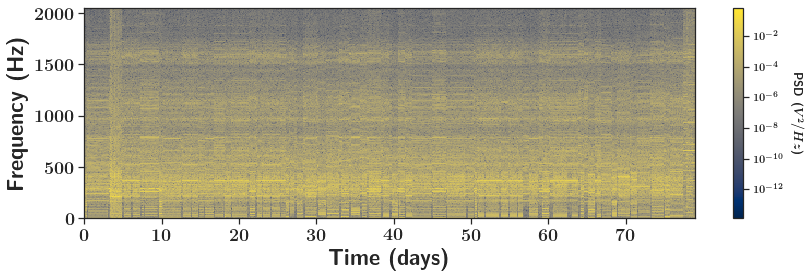

In [24]:
plot_spectrogram(
            ts_full,
            X_full.astype(float).T,
            1,
            size=(12,4),
            showplot = True,
            save_plot = False,
            transparent = True,
            folder = 'Figures/IMS2_Spectrogram/',
            filename = 'Bearing1_Spectrogram',
            xlabelpad = 5,    
            ylabelpad = 5,   
            file_type='png',
#             date_format='%I:00 %p, %b %d',
            xlabel='Time (days)'
            )